# Building metacells with [Metacell-2](https://github.com/tanaylab/metacells)

An example of building *metacells* using the [Metacell-2](https://github.com/tanaylab/metacells) algorithm. 
 
**Data:** cell lines scRNA-seq from [Tian et. al, 2019](https://doi.org/10.1038/s41592-019-0425-8), the same as for the [first tutorial](https://github.com/GfellerLab/SIB_workshop/blob/main/workbooks/Workbook_1__cancer_cell_lines).

*.h5ad* anndata file with scRNA-seq data is located in `'data/cell_lines/anndata_filtered.h5ad'`

For the complete tutorial of metacell construction with the [Metacell-2](https://github.com/tanaylab/metacells), please, follow author's [vignette](https://metacells.readthedocs.io/en/latest/Metacells_Vignette.html) and the [readme](https://metacells.readthedocs.io/en/latest/readme.html) for installation.



## Imports

In [1]:
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import metacells as mc
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import statistics

from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats
from scipy import sparse

set_matplotlib_formats('svg')
sns.set_style("white")

/var/folders/g3/m1nhnz5910s9mckg3ymbz_b80000gn/T/ipykernel_42378/2695548958.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('../../Py/') # make a MC_metrics.py script to stote metric functions

import importlib
import mc_QC
importlib.reload(mc_QC)


<module 'mc_QC' from '/Users/mariiabilous/Documents/PhD/UNIL/R/Metacell_review_analysis/analysis/compute_metacells/../../Py/mc_QC.py'>

## Parameter
Requested graining level

In [4]:
## Parameters
I = 2
proj_name = ["cell_lines", "3k_pbmc"][1]

annotation_label = {'cell_lines':'cell_line',
                   '3k_pbmc':'louvain'}[proj_name]

gamma = [10, 20, 30, 50, 75, 100][I] # the requested graing level

scale = {'cell_lines': [1, 1, 2.8, 2.8, 3, 1],
         '3k_pbmc': [0.5, 1, 2.5,  2.2, 2],
        }[proj_name][I]

MC_tool = "MC2"

## Load data 

In [5]:
# Load data pre-filtered data

data_folder = os.path.join("../../data/", proj_name)
raw = sc.read(os.path.join(data_folder, "anndata_filtered.h5ad"))


In [6]:
# set MC object/project name
mc.ut.set_name(raw, proj_name)
print(raw.shape)

(2638, 32738)


## Gene filtering
Since, lowly expresssed genes have been already removed during data preprocesing (outside of this workbook), there is no need to remove poorly expressed genes usign Metacell-2 pipeline, but we can still remove mitochondrial genes.

In [7]:
excluded_gene_names = [] # for example, ['IGHMBP2', 'IGLL1', 'IGLL5', 'IGLON5', 'NEAT1', 'TMSB10', 'TMSB4X']
excluded_gene_patterns = ['MT-.*']
mc.pl.analyze_clean_genes(raw,
                          excluded_gene_names=excluded_gene_names,
                          excluded_gene_patterns=excluded_gene_patterns,
                          random_seed=123456)

mc.pl.pick_clean_genes(raw)

set 3k_pbmc.var[properly_sampled_gene]: 16579 true (50.64%) out of 32738 bools
set 3k_pbmc.var[excluded_gene]: 13 true (0.03971%) out of 32738 bools
set 3k_pbmc.var[noisy_lonely_gene]: 0 true (0%) out of 32738 bools
set 3k_pbmc.var[clean_gene]: 16566 true (50.6%) out of 32738 bools


## Cell filtering (not applicable to our pre-filtered data)

The first round of cell cleaning usually implies filltering out cell with very low and very hight UMI content. 
The second round includes cell filtering based on mitochondrial and/or ribosomal content. 
We will skip both steps as our data have been pre-filtered and will use very lenient cutoffs (`properly_sampled_min_cell_total`, `properly_sampled_max_cell_total` and `properly_sampled_max_excluded_genes_fraction`) such that all the cells are kept for the metacell construction.

/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Will exclude 0 (0.00%) cells with less than 200 UMIs
Will exclude 0 (0.00%) cells with more than 10000 UMIs


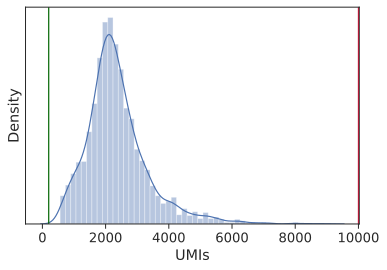

In [8]:
### The first round (high/low UMIs)
properly_sampled_min_cell_total = {'cell_lines' : 5000, '3k_pbmc': 200}[proj_name]
properly_sampled_max_cell_total = {'cell_lines' : 110000, '3k_pbmc': 10000}[proj_name]

total_umis_of_cells = mc.ut.get_o_numpy(raw, name='__x__', sum=True)

plot = sns.distplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')

too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))

Will exclude 0 (0.00%) cells with more than 25.00% excluded gene UMIs


/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


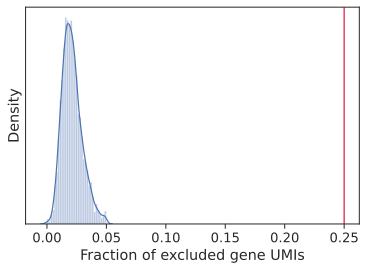

In [9]:
## The second round (content of non-clean genes, e.g., mito-genes)
properly_sampled_max_excluded_genes_fraction = 0.25


excluded_genes_data = mc.tl.filter_data(raw, var_masks=['~clean_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

plot = sns.distplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')

too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)

too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

In [10]:
mc.pl.analyze_clean_cells(
    raw,
    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction
)
mc.pl.pick_clean_cells(raw)

set 3k_pbmc.obs[properly_sampled_cell]: 2638 true (100%) out of 2638 bools
set 3k_pbmc.obs[clean_cell]: 2638 true (100%) out of 2638 bools


In [11]:
# Extract clean dataset (with fillered cells and genes)
clean = mc.pl.extract_clean_data(raw)

set 3k_pbmc.clean.obs[full_cell_index]: 2638 int64s
set 3k_pbmc.clean.var[full_gene_index]: 16566 int64s


## Computing metacells 

Metacell-2 uses its own feature selection approach (i.e., selection of genes used to build metacells). Additionally, we can explicitely specify which features to use by providing two arguments: 
`feature_gene_names` - genes that have to be used 
`forbidden_gene_names` - genes to exclude.


In contrast to the SuperCell and SEACells, Metacell-2 does not allow to explicitely obtain metacell data at a user-defined graining level. Instead, to vary graining level, we have to vary a `target_metacell_size` parameter, that is `160000` by default. Here we provide a chunk to calibrate this value to get a desired graining level. Please, increase  or decrease `scale` if the obtained  grainign level `gamma_obtained` is lower or larger than the requested one (`gamma`).

In [12]:
# Estimate target_metacell_size(gamma):
print(f'The requested graining level is {gamma}, lets estimate the target_metacell_size that should result in such graining level.')

scale # incres or decrease if the obtained graining level (`gamma_obtained`) is significantly > or < then the requested one `gamma`

N_c = clean.shape[0]

# estimated mean UMI content in dowsampled data
est_downsample_UMI = np.quantile(np.array(total_umis_of_cells), 0.05)

target_metacell_size = int(est_downsample_UMI*gamma * scale)
target_metacell_size

The requested graining level is 30, lets estimate the target_metacell_size that should result in such graining level.


76091

In [13]:
scale = 2

In [14]:
mc.pl.divide_and_conquer_pipeline(
    clean,
    #feature_gene_names   = feature_gene_names, # comment this line to allow Metacell2 selecting features
    #forbidden_gene_names = forbidden_gene_names, # comment this line to allow Metacell2 selecting features
    target_metacell_size = target_metacell_size,
    random_seed = 123456)

## make anndata of metacells
metacells = mc.pl.collect_metacells(clean, name='cell_lines.metacells')

set 3k_pbmc.clean.var[rare_gene]: 0 true (0%) out of 16566 bools
set 3k_pbmc.clean.var[rare_gene_module]: 16566 int32 elements with all outliers (100%)
set 3k_pbmc.clean.obs[cells_rare_gene_module]: 2638 int32 elements with all outliers (100%)
set 3k_pbmc.clean.obs[rare_cell]: 0 true (0%) out of 2638 bools
set 3k_pbmc.clean.layers[downsampled]: csr_matrix 2638 X 16566 float32s (1218892 > 0)
set 3k_pbmc.clean.uns[downsample_samples]: 989
set 3k_pbmc.clean.var[high_top3_gene]: 552 true (3.332%) out of 16566 bools
set 3k_pbmc.clean.var[high_total_gene]: 4519 true (27.28%) out of 16566 bools
set 3k_pbmc.clean.var[high_relative_variance_gene]: 3027 true (18.27%) out of 16566 bools
set 3k_pbmc.clean.var[feature_gene]: 293 true (1.769%) out of 16566 bools
set 3k_pbmc.clean.obsp[obs_similarity]: ndarray 2638 X 2638 float32s
set 3k_pbmc.clean.obsp[obs_outgoing_weights]: csr_matrix 2638 X 2638 float32s (88305 > 0)
set 3k_pbmc.clean.obs[seed]: 486 outliers (18.42%) out of 2638 int32 elements with

In [15]:
gamma_obtained = clean.shape[0]/metacells.shape[0]

gamma_obtained

30.32183908045977

Check whether the obtained graining level is acceptable or whether a correction of the parameter `scale` is necessary.

In [16]:
gamma_dev = (gamma_obtained - gamma)/gamma
if abs(gamma_dev) < 0.3: 
    gamma_dev = 0

if gamma_dev < 0:
    print("Increase `target_metacell_size` parameter by increasing `scale` and re-run metacell divide_and_conquer_pipeline() to get larger graining level")
elif gamma_dev > 0:
    print("Deacrease `target_metacell_size` parameter by decreasing `scale` and re-run metacell divide_and_conquer_pipeline() to get smaller graining level")
elif gamma_dev == 0:
    print("The obtained graining level is acceptable, no need to re-run the metacell divide_and_conquer_pipeline() with a new `target_metacell_size` ")

The obtained graining level is acceptable, no need to re-run the metacell divide_and_conquer_pipeline() with a new `target_metacell_size` 


In [17]:
gamma_dev

0

## Visualize metacells (optional)

set cell_lines.metacells.var[top_feature_gene]: 293 true (1.769%) out of 16566 bools
set cell_lines.metacells.obsp[obs_balanced_ranks]: 994 nonzero (13.13%) out of 7569 elements
set cell_lines.metacells.obsp[obs_pruned_ranks]: 357 nonzero (4.717%) out of 7569 elements
set cell_lines.metacells.obsp[obs_outgoing_weights]: 357 nonzero (4.717%) out of 7569 elements
set cell_lines.metacells.obsp[umap_distances]: csr_matrix 87 X 87 float32s (7482 > 0)
/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
set cell_lines.metacells.obs[umap_x]: [ 9.217044, 9.022905, 1.0884279, 14.388029, 14.981547, 11.075375, 10.780715

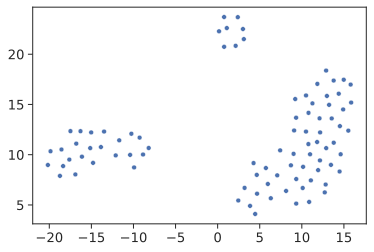

In [18]:
mc.pl.compute_umap_by_features(metacells, max_top_feature_genes=1000,
                               min_dist=2.0, random_seed=123456)
umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')
plot = sns.scatterplot(x=umap_x, y=umap_y)

In [19]:
# make a membership (as in SCimplify() from SuperCell) vector
clean.obs['membership'] = [int(i)+1 if i >= 0 else np.nan for i in clean.obs.metacell] 

## Save single-cell metadata (i.e., `raw.obs` dataframe) in the metacell adata object
metacells.uns = clean.uns.copy()
metacells.uns['sc.obs'] = clean.obs.copy()

# save the requested gamma
metacells.uns['gamma'] = gamma

In [20]:
metacells.uns['sc.obs'][['metacell', annotation_label]].value_counts()

metacell  louvain        
-1        CD4 T cells        323
          CD14+ Monocytes    171
          B cells            147
          CD8 T cells        115
          NK cells            72
                            ... 
 40       B cells              1
 0        CD8 T cells          1
 48       CD4 T cells          1
 66       CD8 T cells          1
 44       NK cells             1
Length: 160, dtype: int64

In [21]:
metacells.var.feature_gene.value_counts()

0    16273
1      293
Name: feature_gene, dtype: int64

In [22]:
metacells.uns['sc.obs']

,n_genes,percent_mito,n_counts,louvain,properly_sampled_cell,clean_cell,full_cell_index,cells_rare_gene_module,rare_cell,seed,...,outlier,pre_cell_directs,cell_directs,pre_pile,pile,pre_candidate,pre_cell_deviant_votes,pre_dissolved,pre_metacell,membership
index,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,True,True,0,-1,False,-1,...,False,0,0,-1,0,-1,0,False,-1,22.0
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,True,True,1,-1,False,67,...,False,0,0,-1,0,-1,0,False,-1,18.0
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,True,True,2,-1,False,42,...,False,0,0,-1,0,-1,0,False,-1,39.0
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,True,True,3,-1,False,15,...,False,0,0,-1,0,-1,0,False,-1,14.0
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,True,True,4,-1,False,-1,...,True,0,0,-1,0,-1,0,False,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,True,True,2633,-1,False,15,...,False,0,0,-1,0,-1,0,False,-1,78.0
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,True,True,2634,-1,False,-1,...,False,0,0,-1,0,-1,0,False,-1,58.0
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,True,True,2635,-1,False,70,...,True,0,0,-1,0,-1,0,False,-1,NaN


In [23]:
metacells.obs

,grouped,pile,candidate,umap_x,umap_y
0,15,0,0,9.217044,15.539177
1,14,0,1,9.022905,10.086907
2,21,0,2,1.088428,22.601950
3,17,0,3,14.388029,16.068642
4,18,0,4,14.981547,17.460321
...,...,...,...,...,...
82,17,0,83,-15.138607,10.657050
83,18,0,84,-10.250227,12.085065
84,15,0,85,-8.862514,10.020442
85,17,0,86,-8.190232,10.668282


## Compute single-cell PCA and DC to further evaluate some MC QC 

In [24]:
# Save count as a separate layer
clean.layers['counts'] = clean.X

# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(clean.layers['counts'])
raw_ad.obs_names, raw_ad.var_names = clean.obs_names, clean.var_names
clean.raw = raw_ad

In [25]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(clean)
sc.pp.log1p(clean)
sc.pp.highly_variable_genes(clean, n_top_genes=1000)


In [26]:
# Compute principal components - 
# Here we use 10 components to be consistent with out main tutorial, but fill free to explore other number of principal components to use 

n_comp    = 10
sc.tl.pca(clean, n_comps=n_comp, use_highly_variable=True)


# Compute UMAP for visualization 
sc.pp.neighbors(clean, n_neighbors=10, n_pcs=n_comp)
sc.tl.umap(clean)

In [27]:
## Save single-cell metadata (i.e., `ad.obs` dataframe) in the seacell adata object
metacells.obs['size'] = [int(x) for x in metacells.obs.grouped]
metacells.obs['membership'] = [int(i)+1 for i in metacells.obs.index]

metacells.uns = clean.uns.copy()
metacells.uns['sc.obs'] = clean.obs.copy()

metacells.var['feature_gene'] = clean.var['highly_variable'].astype(int)
metacells.obs['gamma'] = gamma
metacells.obs['gamma_obtained'] = round(clean.shape[0]/metacells.shape[0])
metacells.obs['MC_tool'] = MC_tool


metacells.obs

,grouped,pile,candidate,umap_x,umap_y,size,membership,gamma,gamma_obtained,MC_tool
0,15,0,0,9.217044,15.539177,15,1,30,30,MC2
1,14,0,1,9.022905,10.086907,14,2,30,30,MC2
2,21,0,2,1.088428,22.601950,21,3,30,30,MC2
3,17,0,3,14.388029,16.068642,17,4,30,30,MC2
4,18,0,4,14.981547,17.460321,18,5,30,30,MC2
...,...,...,...,...,...,...,...,...,...,...
82,17,0,83,-15.138607,10.657050,17,83,30,30,MC2
83,18,0,84,-10.250227,12.085065,18,84,30,30,MC2
84,15,0,85,-8.862514,10.020442,15,85,30,30,MC2
85,17,0,86,-8.190232,10.668282,17,86,30,30,MC2


## Metacell quality metrics

### Purity 

In [28]:
import importlib
importlib.reload(mc_QC)

MC_purity = mc_QC.purity(clean, annotation_label, MC_label = 'membership')
print(MC_purity)
MC_purity.index = metacells.obs.index



metacells.obs = metacells.obs.join(MC_purity) #pd.merge(metacells.obs, MC_purity, left_index=True, right_index=True)



                      louvain  louvain_purity
membership                                   
1.0               CD4 T cells        0.933333
2.0               CD4 T cells        0.857143
3.0                   B cells        1.000000
4.0               CD4 T cells        1.000000
5.0               CD4 T cells        0.944444
...                       ...             ...
83.0          CD14+ Monocytes        0.882353
84.0        FCGR3A+ Monocytes        1.000000
85.0        FCGR3A+ Monocytes        0.933333
86.0        FCGR3A+ Monocytes        1.000000
87.0        FCGR3A+ Monocytes        1.000000

[87 rows x 2 columns]


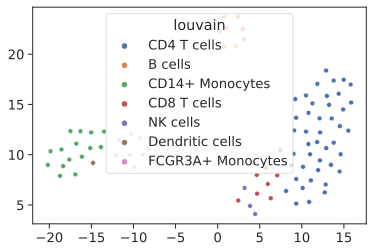

In [29]:
plot = sns.scatterplot(x=umap_x, y=umap_y, hue = metacells.obs[annotation_label])

In [30]:
metacells.obs

,grouped,pile,candidate,umap_x,umap_y,size,membership,gamma,gamma_obtained,MC_tool,louvain,louvain_purity
0,15,0,0,9.217044,15.539177,15,1,30,30,MC2,CD4 T cells,0.933333
1,14,0,1,9.022905,10.086907,14,2,30,30,MC2,CD4 T cells,0.857143
2,21,0,2,1.088428,22.601950,21,3,30,30,MC2,B cells,1.000000
3,17,0,3,14.388029,16.068642,17,4,30,30,MC2,CD4 T cells,1.000000
4,18,0,4,14.981547,17.460321,18,5,30,30,MC2,CD4 T cells,0.944444
...,...,...,...,...,...,...,...,...,...,...,...,...
82,17,0,83,-15.138607,10.657050,17,83,30,30,MC2,CD14+ Monocytes,0.882353
83,18,0,84,-10.250227,12.085065,18,84,30,30,MC2,FCGR3A+ Monocytes,1.000000
84,15,0,85,-8.862514,10.020442,15,85,30,30,MC2,FCGR3A+ Monocytes,0.933333
85,17,0,86,-8.190232,10.668282,17,86,30,30,MC2,FCGR3A+ Monocytes,1.000000


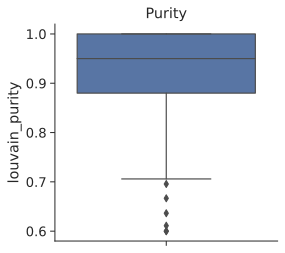

In [31]:
plt.figure(figsize=(4,4))
sns.boxplot(data=MC_purity, y=f'{annotation_label}_purity')
plt.title('Purity')
sns.despine()
plt.show()
plt.close()

## Compactness and separation

In [32]:
import importlib
importlib.reload(mc_QC)

MC_label = 'membership'

compactness_PCA = mc_QC.compactness(clean, 'X_pca', MC_label = MC_label, DO_DC = False, name = 'Compactness_PCA', n_comp=n_comp)['Compactness_PCA']
compactness_DC  = mc_QC.compactness(clean, 'X_pca', MC_label = MC_label, DO_DC = True, name = 'Compactness_DC', n_comp=n_comp)['Compactness_DC']

metacells.obs = metacells.obs.join(compactness_PCA, on = MC_label)
metacells.obs = metacells.obs.join(compactness_DC, on = MC_label )

separation_PCA = mc_QC.separation(clean, 'X_pca', MC_label = MC_label, DO_DC = False, name = 'Separation_PCA', n_comp=n_comp)['Separation_PCA']
separation_DC  = mc_QC.separation(clean, 'X_pca', MC_label = MC_label, DO_DC = True, name = 'Separation_DC', n_comp=n_comp)['Separation_DC']

metacells.obs = metacells.obs.join(separation_PCA, on = MC_label)
metacells.obs = metacells.obs.join(separation_DC, on = MC_label)

metacells.obs

Determing nearest neighbor graph...
Determing nearest neighbor graph...


,grouped,pile,candidate,umap_x,umap_y,size,membership,gamma,gamma_obtained,MC_tool,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC
0,15,0,0,9.217044,15.539177,15,1,30,30,MC2,CD4 T cells,0.933333,0.239342,0.184116,0.395343,0.111617
1,14,0,1,9.022905,10.086907,14,2,30,30,MC2,CD4 T cells,0.857143,0.379468,6.554469,0.353837,1.970844
2,21,0,2,1.088428,22.601950,21,3,30,30,MC2,B cells,1.000000,0.219900,0.035574,0.326401,0.081942
3,17,0,3,14.388029,16.068642,17,4,30,30,MC2,CD4 T cells,1.000000,0.157569,0.001303,0.296543,0.017391
4,18,0,4,14.981547,17.460321,18,5,30,30,MC2,CD4 T cells,0.944444,0.216192,0.004020,0.200466,0.018115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,17,0,83,-15.138607,10.657050,17,83,30,30,MC2,CD14+ Monocytes,0.882353,0.282443,0.165198,0.536193,0.139020
83,18,0,84,-10.250227,12.085065,18,84,30,30,MC2,FCGR3A+ Monocytes,1.000000,0.149644,0.078650,0.492197,0.289403
84,15,0,85,-8.862514,10.020442,15,85,30,30,MC2,FCGR3A+ Monocytes,0.933333,0.357115,5.064726,0.340699,2.063912
85,17,0,86,-8.190232,10.668282,17,86,30,30,MC2,FCGR3A+ Monocytes,1.000000,0.157093,0.048932,0.340699,0.205733


In [33]:
# compute extra PC to evaluate performance of compactness and separation outside the n_comp used for MC construction
sc.tl.pca(clean, n_comps=50, use_highly_variable=True)
clean.obsm['X_pca'].shape

(2638, 50)

### Compute *compactness* for a range of latent space components 


In [34]:
QC_compactness = pd.DataFrame()

# Compactness

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    
    compactness_PCA_i = mc_QC.compactness(clean, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = MC_label)
    compactness_DC_i  = mc_QC.compactness(clean, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = MC_label)
    
    QC_compactness = pd.concat([QC_compactness, compactness_PCA_i, compactness_DC_i], ignore_index=True)
QC_compactness


2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,compactness,low_dim_embedding,n_comp,membership
0,0.393925,X_pca,2,1.0
1,0.383980,X_pca,2,2.0
2,0.195402,X_pca,2,3.0
3,0.060292,X_pca,2,4.0
4,0.139698,X_pca,2,5.0
...,...,...,...,...
2605,0.015554,DC,30,83.0
2606,0.010805,DC,30,84.0
2607,0.552976,DC,30,85.0
2608,0.008820,DC,30,86.0


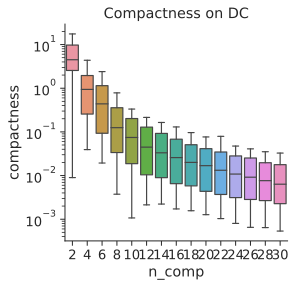

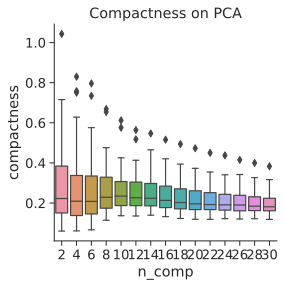

In [35]:

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'DC'], y='compactness', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Compactness on DC')
sns.despine()
plt.show()
plt.close()

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'X_pca'], y='compactness', x = 'n_comp')
#plt.yscale('log')
plt.title('Compactness on PCA')
sns.despine()
plt.show()
plt.close()



### Compute *separation* for a range of latent space components 

In [36]:
importlib.reload(mc_QC)
QC_separation = pd.DataFrame()

#Separation

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    sep_PCA_i = mc_QC.separation(clean, 'X_pca', MC_label = MC_label, n_comp = n_comp_i, DO_DC = False)
    sep_DC_i = mc_QC.separation(clean, 'X_pca', MC_label = MC_label, n_comp = n_comp_i, DO_DC = True)
    
    
    QC_separation = pd.concat([QC_separation, sep_PCA_i, sep_DC_i], ignore_index=True)
QC_separation

2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,separation,low_dim_embedding,n_comp,membership
0,0.024383,X_pca,2,1.0
1,0.053817,X_pca,2,2.0
2,0.033570,X_pca,2,3.0
3,0.013932,X_pca,2,4.0
4,0.019217,X_pca,2,5.0
...,...,...,...,...
2605,0.159080,DC,30,83.0
2606,0.279535,DC,30,84.0
2607,1.000485,DC,30,85.0
2608,0.180052,DC,30,86.0


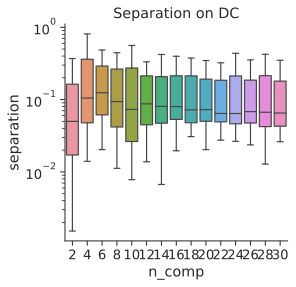

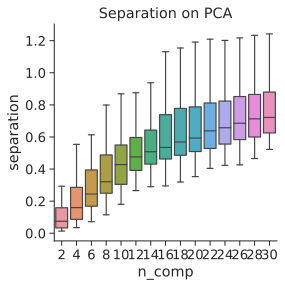

In [37]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'DC'], y='separation', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Separation on DC')
sns.despine()
plt.show()
plt.close()

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'X_pca'], y='separation', x = 'n_comp', showfliers = False)
#plt.yscale('log')
plt.title('Separation on PCA')
sns.despine()
plt.show()
plt.close()

In [38]:
QC = QC_compactness.merge(QC_separation, on=['low_dim_embedding', 'n_comp', 'membership'])

QC['membership'] = [int(x) for x in QC['membership']]
QC = metacells.obs.iloc[:,5:12].merge(QC, on = MC_label)

QC

,size,membership,gamma,gamma_obtained,MC_tool,louvain,louvain_purity,compactness,low_dim_embedding,n_comp,separation
0,15,1,30,30,MC2,CD4 T cells,0.933333,0.393925,X_pca,2,0.024383
1,15,1,30,30,MC2,CD4 T cells,0.933333,8.729183,DC,2,0.001518
2,15,1,30,30,MC2,CD4 T cells,0.933333,0.278533,X_pca,4,0.125483
3,15,1,30,30,MC2,CD4 T cells,0.933333,1.990010,DC,4,0.105001
4,15,1,30,30,MC2,CD4 T cells,0.933333,0.248712,X_pca,6,0.235446
...,...,...,...,...,...,...,...,...,...,...,...
2605,17,87,30,30,MC2,FCGR3A+ Monocytes,1.000000,0.040350,DC,26,0.182204
2606,17,87,30,30,MC2,FCGR3A+ Monocytes,1.000000,0.147123,X_pca,28,0.688617
2607,17,87,30,30,MC2,FCGR3A+ Monocytes,1.000000,0.032121,DC,28,0.162810
2608,17,87,30,30,MC2,FCGR3A+ Monocytes,1.000000,0.141011,X_pca,30,0.691968


Text(0.3, 0, 'r = 0.3982')

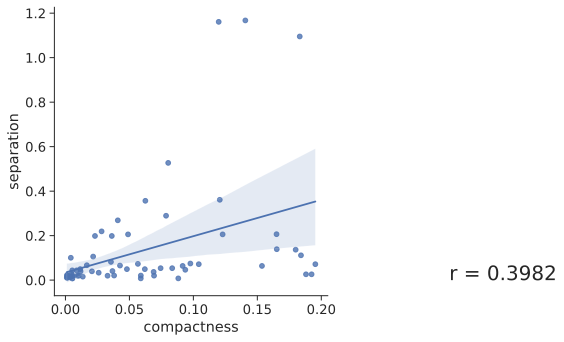

In [39]:
import scipy
df = QC[(QC['low_dim_embedding'] == 'DC') & (QC['n_comp'] == 10)]
#df['size'] = mc_size.cell_line
df = df[(df['separation']<100) & (df['compactness']<.2)]
r = df.compactness.corr(df.separation)

#sns.scatterplot(x="compactness", y="separation", data=df)
sns.lmplot(x="compactness", y="separation", data=df)

#add correlation coefficient to plot
plt.text(.3,0, 'r = ' + str(round(r, 4)), fontsize=20)

In [40]:
clean.X.A.sum(axis = 0)

array([ 5.665485  ,  1.9371629 ,  2.4421146 , ...,  0.75441265,
       69.94173   , 42.65932   ], dtype=float32)

## INV

In [41]:
mc_INV = mc_QC.mc_inner_normalized_var(clean, MC_label=MC_label)

/Users/mariiabilous/opt/anaconda3/envs/metacells/lib/python3.8/site-packages/pandas/core/arraylike.py:490: RuntimeWarning: divide by zero encountered in reciprocal
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [42]:
mc_INV.shape

(87, 16566)

In [43]:
clean.obs.membership

index
AAACATACAACCAC-1    22.0
AAACATTGAGCTAC-1    18.0
AAACATTGATCAGC-1    39.0
AAACCGTGCTTCCG-1    14.0
AAACCGTGTATGCG-1     NaN
                    ... 
TTTCGAACTCTCAT-1    78.0
TTTCTACTGAGGCA-1    58.0
TTTCTACTTCCTCG-1     NaN
TTTGCATGAGAGGC-1    58.0
TTTGCATGCCTCAC-1     NaN
Name: membership, Length: 2638, dtype: float64

In [44]:
mc_INV_val = mc_INV.quantile([0.05, 0.5, 0.95], axis=1, numeric_only=True)
mc_INV_val = pd.DataFrame(mc_INV_val.transpose()).set_axis(['INV_5', 'INV_50','INV_95'], axis=1, inplace=False)
metacells.obs = metacells.obs.join(mc_INV_val, on = MC_label)

In [45]:
metacells.obs

,grouped,pile,candidate,umap_x,umap_y,size,membership,gamma,gamma_obtained,MC_tool,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC,INV_5,INV_50,INV_95
0,15,0,0,9.217044,15.539177,15,1,30,30,MC2,CD4 T cells,0.933333,0.239342,0.184116,0.395343,0.111617,0.000145,0.002576,0.117287
1,14,0,1,9.022905,10.086907,14,2,30,30,MC2,CD4 T cells,0.857143,0.379468,6.554469,0.353837,1.970844,0.000150,0.002733,0.128129
2,21,0,2,1.088428,22.601950,21,3,30,30,MC2,B cells,1.000000,0.219900,0.035574,0.326401,0.081942,0.000326,0.002581,0.115200
3,17,0,3,14.388029,16.068642,17,4,30,30,MC2,CD4 T cells,1.000000,0.157569,0.001303,0.296543,0.017391,0.000254,0.001613,0.087206
4,18,0,4,14.981547,17.460321,18,5,30,30,MC2,CD4 T cells,0.944444,0.216192,0.004020,0.200466,0.018115,0.000595,0.002848,0.110176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,17,0,83,-15.138607,10.657050,17,83,30,30,MC2,CD14+ Monocytes,0.882353,0.282443,0.165198,0.536193,0.139020,0.000266,0.001751,0.131137
83,18,0,84,-10.250227,12.085065,18,84,30,30,MC2,FCGR3A+ Monocytes,1.000000,0.149644,0.078650,0.492197,0.289403,0.000136,0.001193,0.099171
84,15,0,85,-8.862514,10.020442,15,85,30,30,MC2,FCGR3A+ Monocytes,0.933333,0.357115,5.064726,0.340699,2.063912,0.000087,0.001531,0.130840
85,17,0,86,-8.190232,10.668282,17,86,30,30,MC2,FCGR3A+ Monocytes,1.000000,0.157093,0.048932,0.340699,0.205733,0.000198,0.001442,0.104312


In [46]:
metacells.uns['QC_separation_compactness_PC_range'] = QC

## Saving data for the further downstream analysis

In [48]:
meth_name = 'mc2'
metacells.write(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}.h5ad'))
metacells.obs.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_metacell_obs.csv'))
clean.obs.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_singlecell_obs.csv'))
QC.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_QC.csv'))


In [49]:
gamma

30